## Additional Sentiment Analysis

In [1]:
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as sk_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from textblob import TextBlob

import gensim
import json
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os.path
import pandas as pd
import re
import string
import tmdb3 as tmdb
import tmdbsimple as t_simple

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 7})
%config InlineBackend.figure_format = 'png2x'

### Creating Dataset

In [3]:
tmdb.set_key('98ca260f92ac9b42606914b232546089')
t_simple.API_KEY = '98ca260f92ac9b42606914b232546089'

In [4]:
def get_page(discover, year, page):
    results = discover.movie(page=page, sort_by='popularity.desc', primary_release_year=year)['results']
    return [movie['id'] for movie in results]

# Merge lists of lists into a single list
def flatten(lst):
    return list(chain.from_iterable(lst))

def get_yearly_ids(discover, year):
    # Ensure that we do not make more than 40 requests per 10 seconds
    sleep(10)
    return flatten([get_page(discover, year, page) for page in range(1, 26)])

def get_all_ids():
    discover = t_simple.Discover()
    results = flatten([get_yearly_ids(discover, year) for year in range(2000, 2017)])
    
    # Remove Super Gals (2001) from the list since it can no longer be found with the API
    super_gals = 440656
    if super_gals in results:
        results.remove(super_gals)
        
    return results

def list_to_str(lst):
    return ', '.join([x.name for x in lst])

def get_role(crew, role):
    return next((person.name for person in crew if person.job == role), None)

def get_actor(cast, main):
    return cast[0 if main else (1 if len(cast) > 1 else 0)].name if len(cast) > 0 else None

def get_row(m):
    return {'id': m.id, 'title': m.title, 'tagline': m.tagline, 'overview': m.overview, 'runtime': m.runtime, 
            'budget': m.budget, 'revenue': m.revenue, 'releasedate': m.releasedate, 'popularity': m.popularity, 
            'userrating': m.userrating, 'votes': m.votes, 'adult': m.adult, 'genres': list_to_str(m.genres), 
            'studios': list_to_str(m.studios), 'countries': list_to_str(m.countries), 
            'keywords': list_to_str(m.keywords), 'director': get_role(m.crew, 'Director'), 
            'producer': get_role(m.crew, 'Producer'), 'editor': get_role(m.crew, 'Editor'), 
            'main_actor': get_actor(m.cast, True), 'supporting_actor': get_actor(m.cast, False), 
            'poster': m.poster.geturl('w500') if m.poster else None}

def get_all_movies(movie_ids):
    return pd.DataFrame([get_row(tmdb.Movie(m_id)) for m_id in movie_ids])

def genre_to_matrix(genre_str):
    genres = genre_str.split(', ')
    return [(1 if g in genres else 0) for g in genre_lst]

def get_genre_lst():
    genres = json.loads(tmdb.request.Request('/genre/movie/list').read())['genres']
    return [genre['name'] for genre in genres]

def get_posters(links, indices):
    posters = [(Image.open(StringIO(urllib.urlopen(img).read())), sleep(0.25))[0] for img in links]
    return pd.DataFrame({'poster': posters}, index=indices)

In [5]:
movie_path = './datasets/movies.csv'; poster_path = './datasets/posters.pkl'

if os.path.isfile(movie_path):
    movies = pd.read_csv(movie_path)
else:
    movies = get_all_movies(get_all_ids())
    movies.to_csv(movie_path)
    
movies.set_index('id', inplace=True)

# Drop movies without posters
movies = movies.loc[movies['poster'].dropna().index]

# Convert genre lists to binary lists
genre_lst = get_genre_lst()
genres = [genre_to_matrix(str(genres)) for genres in movies['genres']]

# Set up metadata dataset
metadata = movies.drop(labels=['genres', 'poster'], axis=1)
metadata.head(3)

,adult,budget,countries,director,editor,keywords,main_actor,overview,popularity,producer,releasedate,revenue,runtime,studios,supporting_actor,tagline,title,userrating,votes
id,,,,,,,,,,,,,,,,,,,
77,False,9000000,United States of America,Christopher Nolan,Dody Dorn,"individual, insulin, tattoo, waitress, amnesia...",Guy Pearce,Suffering short-term memory loss after a head ...,3.666593,Jennifer Todd,2000-10-20,39723096,113.0,"Summit Entertainment, Newmarket Capital Group,...",Joe Pantoliano,Some memories are best forgotten.,Memento,8.0,2927
98,False,103000000,"United Kingdom, United States of America",Ridley Scott,Pietro Scalia,"rome, gladiator, roman empire, slavery, battle...",Russell Crowe,General Maximus' success in battle earns the f...,4.943334,David Franzoni,2000-05-01,457640427,155.0,"DreamWorks SKG, Universal Pictures, Scott Free...",Joaquin Phoenix,A Hero Will Rise.,Gladiator,7.8,4343
107,False,10000000,"United Kingdom, United States of America",Guy Ritchie,Jon Harris,"gypsy, bare knuckle boxing, slang, trailer par...",Jason Statham,The second film from British director Guy Ritc...,4.769231,Matthew Vaughn,2000-09-01,83557872,103.0,"Columbia Pictures Corporation, Screen Gems, SK...",Brad Pitt,Stealin' Stones and Breakin' Bones.,Snatch,7.6,2414


### Sentiment Analysis

#### Subjectivity & Polarity Scores

In [6]:
# new dataframe just with the strings
new = pd.DataFrame(metadata['keywords'] + ' ' + metadata['overview'] + ' ' + metadata['tagline'])
new.columns = ['text']

# save the null indices
nullrows = []
for i in range(new.shape[0]):
    if pd.isnull(new.iloc[i, 0]) == True: 
        nullrows.append(new.index[i])

In [7]:
# try to replace null rows with some part of the word summaries
for row in nullrows:
    if ((pd.isnull(metadata['tagline'][row]) == True) & 
        (pd.isnull(metadata['overview'][row]) == True) & (pd.isnull(metadata['keywords'][row]) == True)): 
        new.loc[row] = new.loc[row]
    elif (pd.isnull(metadata['tagline'][row]) == True) & (pd.isnull(metadata['overview'])[row] == True):
        new.loc[row] = metadata['keywords'][row]
    elif (pd.isnull(metadata['tagline'][row]) == True) & (pd.isnull(metadata['keywords'])[row] == True):
        new.loc[row] = metadata['overview'][row]
    elif (pd.isnull(metadata['keywords'][row]) == True) & (pd.isnull(metadata['overview'])[row] == True):
        new.loc[row] = metadata['tagline'][row]
    elif (pd.isnull(metadata['keywords'][row]) == True):
        new.loc[row] = metadata['tagline'][row] + ' ' + metadata['overview'][row]
    elif (pd.isnull(metadata['tagline'][row]) == True):
        new.loc[row] = metadata['keywords'][row] + ' ' + metadata['overview'][row]
    elif (pd.isnull(metadata['overview'][row]) == True):
        new.loc[row] = metadata['keywords'][row] + ' ' + metadata['tagline'][row]
        
# drop any remaining 
new = new.dropna()

In [8]:
# apply the sentiment analysis to each summary
tok_reviews = []
for i in range(0,new.shape[0]):
    tok_reviews.append(TextBlob(new.iloc[i, 0].decode('utf-8')).sentiment)
    
# save polarity and subjectivity score
new['tok_reviews'] = tok_reviews

# create a series of the polarity and subjectivity score of each review
new[['polarity', 'subjectivity']] = new['tok_reviews'].apply(pd.Series)

polarity = []
subjectivity = []

for index in metadata.index:
    try:
        # append polarity & subjectivity scores if index exists in "new" dataframe
        polarity.append(new['polarity'][index])
        subjectivity.append(new['subjectivity'][index])
    except:
        # if that index was one of the ones removed & thus is null, we simply add 'Null' to the index
        # we can change this later based on how we want to approach this issue
        polarity.append(None)
        subjectivity.append(None)

# new columns in metadata
metadata['polarity'] = polarity
metadata['subjectivity'] = subjectivity

#### Most Frequent Words per Genre

In [9]:
def genre_freq(genre, subset):
    # keep only the part of the dataframe that has movies in specific genre
    temp = movies[pd.notnull(movies['genres'])]
    # decide whether to subset the dataset or not
    if subset == True:
        indices = temp[temp['genres'].str.contains(genre)].index
    else:
        indices = temp.index
    subset_new = new.ix[indices]
    subset_new = subset_new.dropna()
    # create an array for sentences 
    sentences = []

    # implements vectorizer and gets rid of stop words like 'and' and 'there'
    vect = CountVectorizer(stop_words='english')
    # implements a stemmer to group words that have the same stems 
    stemmer = PorterStemmer()

    # iterate through the data  
    for index, row in subset_new.iterrows():
        # takes out the numbers from each sentence
        letters_only = re.sub('[^a-zA-Z]', ' ', row.text)
        # tokenize the sentence in order to stem the words
        tokenize = nltk.word_tokenize(letters_only)
        # finds the stem of each word 
        for i in range(len(tokenize)):
            tokenize[i] = stemmer.stem(tokenize[i]).lower()
        # appends each edited sentence (without numbers and with stems) to sentences array
        sentences.append(' '.join(tokenize))
    
    # create dictionary of frequency of each word
    words = [word for word in nltk.word_tokenize(''.join(sentences)) if word not in stopwords.words('english')]
    freq = nltk.FreqDist(words)
    
    # convert dictionary of frequencies to dataframe
    explore_freq = pd.DataFrame.from_dict(freq.most_common(20))
    explore_freq.columns = ['Words', 'Frequency']

    return(explore_freq)

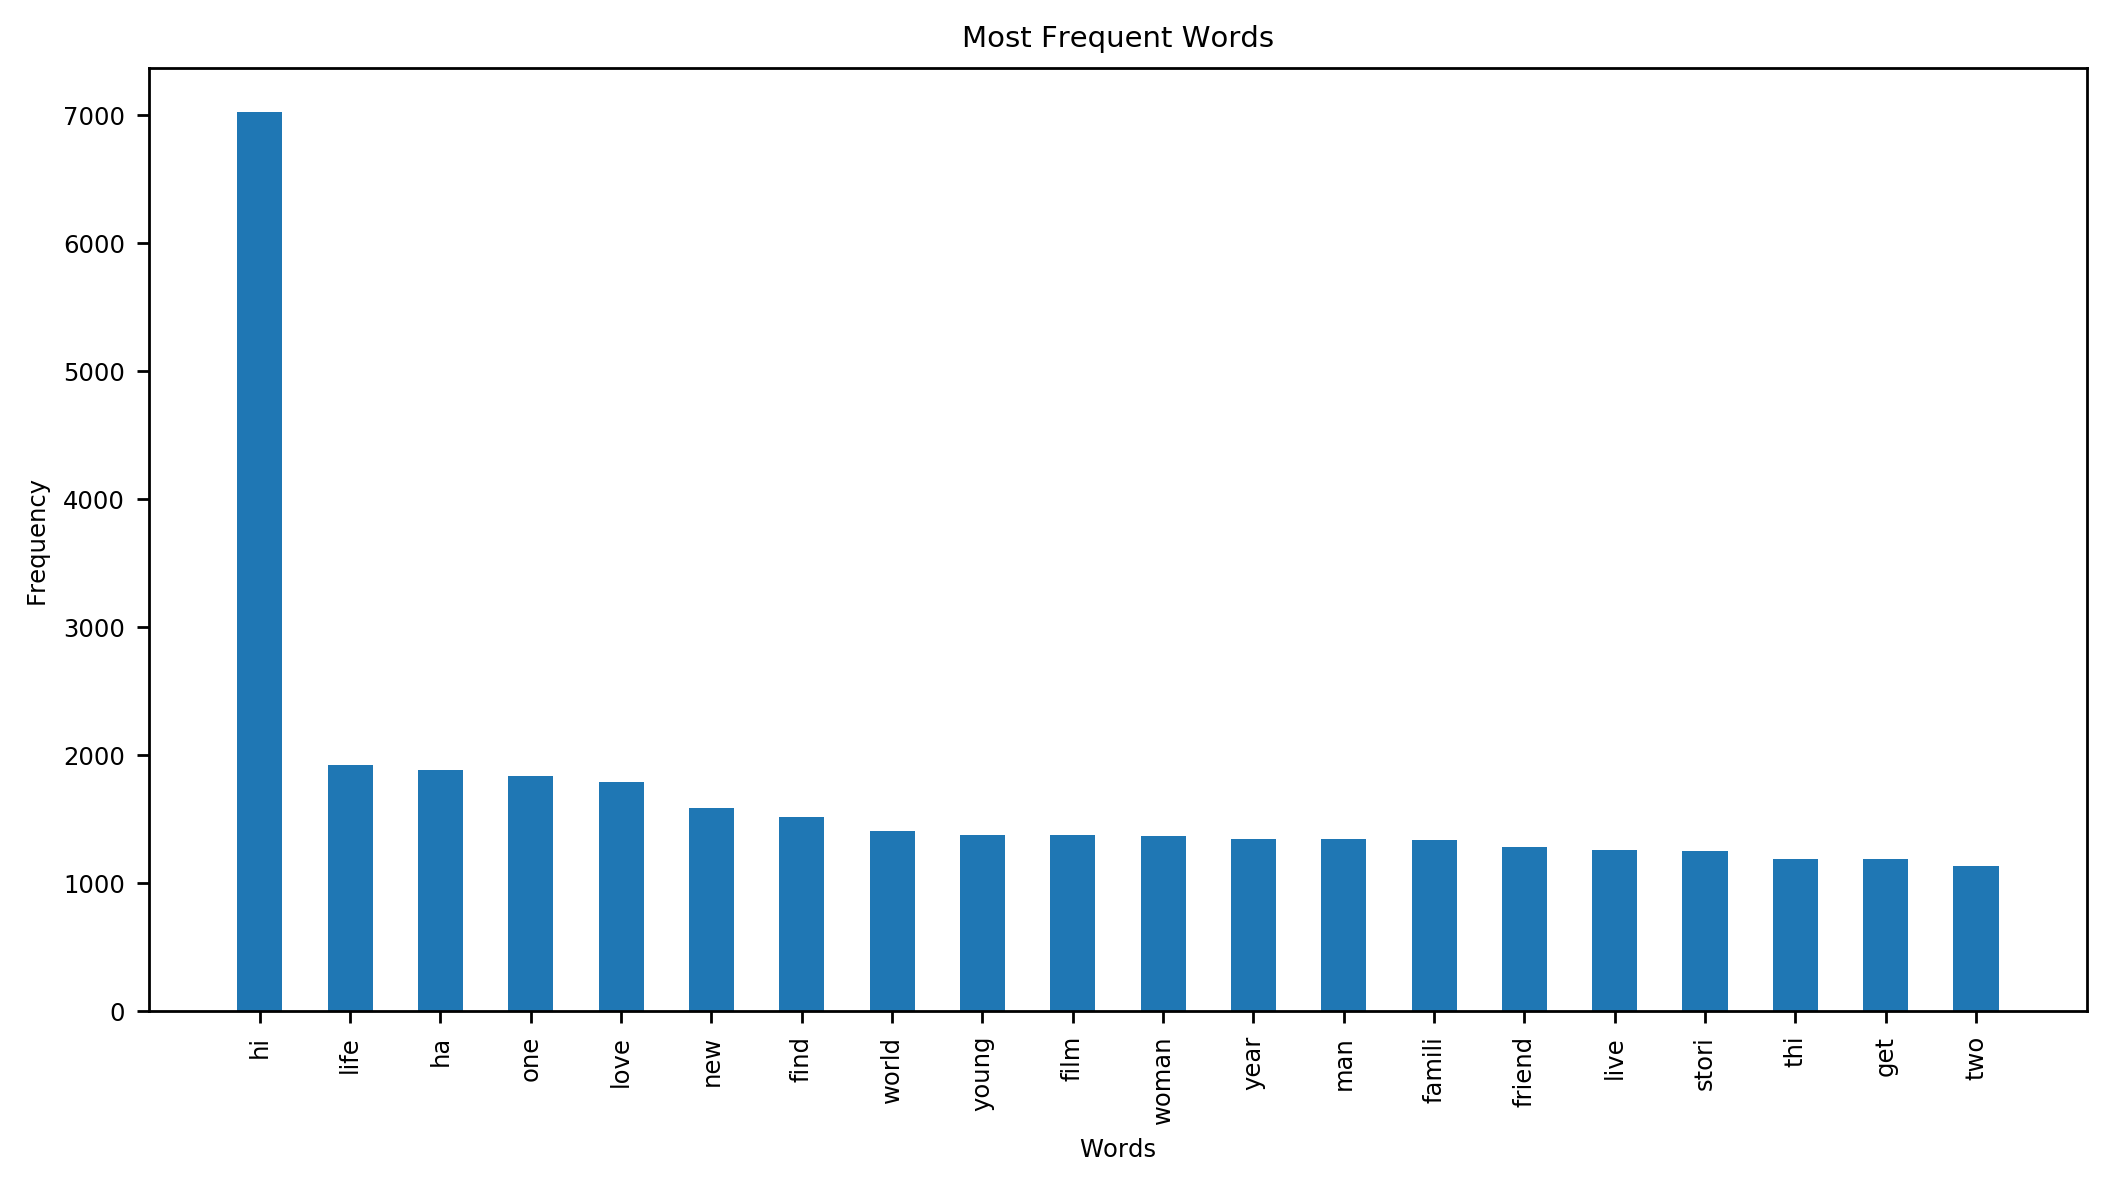

In [10]:
# visualize the most frequent words
explore_freq = genre_freq('none', False)

# create bar graph for the most frequent words 
X = np.arange(20)
plt.figure(figsize=(10, 5), dpi=125)
plt.bar(X, explore_freq.iloc[:20, 1], width=0.5)

# label and rotate the x-ticks
plt.xticks(X, explore_freq.iloc[:20, 0], rotation=90)

# label the graph and the axes
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()